In [80]:
import cv2
import numpy as np
import click
import matplotlib.pyplot as plt
import sys
from scipy import ndimage
from skimage import io
from scipy import ndimage
from PIL import Image
# from matplotlib import pyplot as plt
# from matplotlib import image as mpimg

In [81]:
def convolution(img, kernel):
    """ This function executes the convolution between `img` and `kernel`.
    """
    print("[{}]\tRunning convolution...\n".format(img))
    # Load the image.
    image = cv2.imread(img)
    # Flip template before convolution.
    kernel = cv2.flip(kernel, -1)
    # Get size of image and kernel. 3rd value of shape is colour channel.
    (image_h, image_w) = image.shape[:2]
    (kernel_h, kernel_w) = kernel.shape[:2]
    (pad_h, pad_w) = (kernel_h // 2, kernel_w // 2)
    # Create image to write to.
    output = np.zeros(image.shape)
    # Slide kernel across every pixel.
    for y in range(pad_h, image_h - pad_h):
        for x in range(pad_w, image_w - pad_w):
            # If coloured, loop for colours.
            for colour in range(image.shape[2]):
                # Get center pixel.
                center = image[
                    y - pad_h : y + pad_h + 1, x - pad_w : x + pad_w + 1, colour
                ]
                # Perform convolution and map value to [0, 255].
                # Write back value to output image.
                output[y, x, colour] = (center * kernel).sum() / 255

    # Return the result of the convolution.
    return output


In [82]:
img = 'C:/Users/ameer/Downloads/hybrid-images/data/cat.bmp'
kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
convolution(img, kernel)

[C:/Users/ameer/Downloads/hybrid-images/data/cat.bmp]	Running convolution...



array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.05490196,  0.08627451,  0.01960784],
        [-0.1254902 , -0.07058824,  0.01568627],
        ...,
        [ 0.02745098,  0.00784314,  0.01960784],
        [ 0.08235294,  0.09411765,  0.02352941],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.05098039,  0.05882353,  0.1254902 ],
        [-0.04313725, -0.02352941,  0.00784314],
        ...,
        [ 0.03529412,  0.        ,  0.01176471],
        [ 0.07843137,  0.05490196,  0.04705882],
        [ 0.        ,  0.        ,  0.        ]],

       ...,

       [[ 0.        ,  0.        ,  0.        ],
        [ 0

In [83]:
def fourier(img, kernel):
    """ Compute convolution between `img` and `kernel` using numpy's FFT.
    """
    # Load the image.
    image = cv2.imread(img)
    # Get size of image and kernel.
    (image_h, image_w) = image.shape[:2]
    (kernel_h, kernel_w) = kernel.shape[:2]
    # Apply padding to the kernel.
    padded_kernel = np.zeros(image.shape[:2])
    start_h = (image_h - kernel_h) // 2
    start_w = (image_w - kernel_w) // 2
    padded_kernel[start_h : start_h + kernel_h, start_w : start_w + kernel_w] = kernel
    # Create image to write to.
    output = np.zeros(image.shape)
    # Run FFT on all 3 channels.
    for colour in range(3):
        Fi = np.fft.fft2(image[:, :, colour])
        Fk = np.fft.fft2(padded_kernel)
        # Inverse fourier.
        output[:, :, colour] = np.fft.fftshift(np.fft.ifft2(Fi * Fk)) / 255

    # Return the result of convolution.
    return output

In [84]:
# img = 'C:/Users/ameer/Downloads/hybrid-images/data/cat.bmp'
# kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
fourier(img, kernel)

C:\Users\ameer\AppData\Local\Temp\ipykernel_36872\1634469265.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  output[:, :, colour] = np.fft.fftshift(np.fft.ifft2(Fi * Fk)) / 255


array([[[ 0.05490196,  0.08627451,  0.01960784],
        [-0.1254902 , -0.07058824,  0.01568627],
        [-0.00784314, -0.07058824, -0.01568627],
        ...,
        [ 0.08235294,  0.09411765,  0.02352941],
        [ 0.54509804,  0.23529412,  0.0745098 ],
        [-0.09019608,  0.09411765,  0.10196078]],

       [[ 0.05098039,  0.05882353,  0.1254902 ],
        [-0.04313725, -0.02352941,  0.00784314],
        [ 0.01176471, -0.01568627,  0.00784314],
        ...,
        [ 0.07843137,  0.05490196,  0.04705882],
        [ 0.38039216,  0.15686275,  0.0627451 ],
        [ 0.07058824,  0.18823529,  0.23921569]],

       [[ 0.10980392,  0.08235294,  0.03921569],
        [-0.05882353, -0.0745098 , -0.0627451 ],
        [-0.03529412, -0.0745098 , -0.07843137],
        ...,
        [ 0.08627451,  0.07843137,  0.03137255],
        [ 0.30588235,  0.10980392,  0.00784314],
        [ 0.14509804,  0.23137255,  0.17647059]],

       ...,

       [[ 0.15294118,  0.18039216,  0.18431373],
        [ 0

In [85]:
def gaussian_blur(image, sigma, flag):
    """ Builds a Gaussian kernel used to perform the LPF on an image.
    """
    print("[{}]\tCalculating Gaussian kernel...".format(image))

    # Calculate size of filter.
    size = 8 * sigma + 1
    if not size % 2:
        size = size + 1

    center = size // 2
    kernel = np.zeros((size, size))

    # Generate Gaussian blur.
    for y in range(size):
        for x in range(size):
            diff = (y - center) ** 2 + (x - center) ** 2
            kernel[y, x] = np.exp(-diff / (2 * sigma ** 2))

    kernel = kernel / np.sum(kernel)

    if flag:
        return fourier(image, kernel)
    else:
        return convolution(image, kernel)


In [86]:
gaussian_blur(img, 1, 1)

[C:/Users/ameer/Downloads/hybrid-images/data/cat.bmp]	Calculating Gaussian kernel...


C:\Users\ameer\AppData\Local\Temp\ipykernel_36872\1634469265.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  output[:, :, colour] = np.fft.fftshift(np.fft.ifft2(Fi * Fk)) / 255


array([[[0.42296948, 0.60894729, 0.76896906],
        [0.33230261, 0.53721632, 0.72602237],
        [0.2577579 , 0.47176422, 0.6855529 ],
        ...,
        [0.59754503, 0.71290475, 0.83411863],
        [0.59308048, 0.71604814, 0.83446401],
        [0.52074097, 0.67483162, 0.80822151]],

       [[0.46396772, 0.64759632, 0.81191129],
        [0.3619418 , 0.56699772, 0.76192846],
        [0.27217589, 0.49090605, 0.71340693],
        ...,
        [0.61502873, 0.72556613, 0.84000756],
        [0.62016713, 0.73920595, 0.85414386],
        [0.56093768, 0.71178586, 0.8463602 ]],

       [[0.49475345, 0.66895903, 0.82577451],
        [0.38974279, 0.58785926, 0.7742978 ],
        [0.29150975, 0.50803405, 0.723401  ],
        ...,
        [0.62056873, 0.73223009, 0.84207602],
        [0.63251045, 0.74960476, 0.86008736],
        [0.5852898 , 0.72899971, 0.85796856]],

       ...,

       [[0.34186221, 0.35835162, 0.37316558],
        [0.40677068, 0.40905504, 0.4120824 ],
        [0.45160034, 0

In [87]:
def low_pass(image, cutoff, flag):
    """ Generate low pass filter of image.
    """
    print("[{}]\tGenerating low pass image...".format(image))
    return gaussian_blur(image, cutoff, flag)


In [88]:
image = 'C:/Users/ameer/Downloads/hybrid-images/data/cat.bmp'
low_pass(image, 7, 1)

[C:/Users/ameer/Downloads/hybrid-images/data/cat.bmp]	Generating low pass image...
[C:/Users/ameer/Downloads/hybrid-images/data/cat.bmp]	Calculating Gaussian kernel...


C:\Users\ameer\AppData\Local\Temp\ipykernel_36872\1634469265.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  output[:, :, colour] = np.fft.fftshift(np.fft.ifft2(Fi * Fk)) / 255


array([[[0.38330338, 0.53889392, 0.69715479],
        [0.38113114, 0.53286305, 0.68983926],
        [0.37734037, 0.52566395, 0.68216588],
        ...,
        [0.37861067, 0.54800199, 0.7147068 ],
        [0.38210147, 0.54659212, 0.70977589],
        [0.3836624 , 0.54352565, 0.7038702 ]],

       [[0.37326249, 0.53461311, 0.69933101],
        [0.36967686, 0.52802274, 0.69237498],
        [0.36433965, 0.52010382, 0.68491324],
        ...,
        [0.37169212, 0.54433826, 0.71502392],
        [0.37435269, 0.54290299, 0.71082707],
        [0.37486625, 0.53963087, 0.70554714]],

       [[0.36403728, 0.53096721, 0.70183629],
        [0.35917749, 0.52390852, 0.69526732],
        [0.35243379, 0.51536377, 0.68804557],
        ...,
        [0.36521026, 0.54107384, 0.71560076],
        [0.36715732, 0.53968352, 0.71215812],
        [0.36675082, 0.53628483, 0.70752727]],

       ...,

       [[0.4170859 , 0.55528248, 0.69345685],
        [0.41964024, 0.55131621, 0.68528094],
        [0.4209432 , 0

In [89]:
def high_pass(image, cutoff, flag):
    """ Generate high pass filter of image. This is simply the image minus its
    low passed result.
    """
    print("[{}]\tGenerating high pass image...".format(image))
    return (cv2.imread(image) / 255) - low_pass(image, cutoff, flag)



In [90]:
image = 'C:/Users/ameer/Downloads/hybrid-images/data/dog.bmp'
high_pass(image, 7, 1)

[C:/Users/ameer/Downloads/hybrid-images/data/dog.bmp]	Generating high pass image...
[C:/Users/ameer/Downloads/hybrid-images/data/dog.bmp]	Generating low pass image...
[C:/Users/ameer/Downloads/hybrid-images/data/dog.bmp]	Calculating Gaussian kernel...


C:\Users\ameer\AppData\Local\Temp\ipykernel_36872\1634469265.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  output[:, :, colour] = np.fft.fftshift(np.fft.ifft2(Fi * Fk)) / 255


array([[[ 0.50439052,  0.52386863,  0.54624261],
        [ 0.47344156,  0.49246421,  0.51470741],
        [ 0.44374669,  0.46231419,  0.48447108],
        ...,
        [-0.27161452, -0.2624282 , -0.25900409],
        [-0.29105075, -0.28237749, -0.27921611],
        [-0.31102178, -0.29499589, -0.31166214]],

       [[ 0.4896943 ,  0.50683479,  0.52911069],
        [ 0.45678922,  0.47334793,  0.49564341],
        [ 0.42526691,  0.4412556 ,  0.46361043],
        ...,
        [-0.29184939, -0.26890585, -0.28172579],
        [-0.30945465, -0.2871615 , -0.30009178],
        [-0.33543765, -0.30985085, -0.33461161]],

       [[ 0.47623372,  0.4911689 ,  0.51376074],
        [ 0.44154263,  0.45577805,  0.47856988],
        [ 0.40835449,  0.42191287,  0.44493806],
        ...,
        [-0.27608168, -0.28633377, -0.27586289],
        [-0.30344569, -0.31447665, -0.30393195],
        [-0.33134217, -0.3235218 , -0.340308  ]],

       ...,

       [[-0.22042082, -0.2131136 , -0.20418308],
        [-0

In [97]:
def hybrid_image(images, cutoff, flag):
    """ Create a hybrid image by summing together the low and high frequency
    images.
    """
    # Perform low pass filter and export.
    low = low_pass(images[0], cutoff[0], flag)
#     cv2.imwrite("low.jpg", low * 255)
    # Perform high pass filter and export.
    high = high_pass(images[1], cutoff[1], flag)
#     cv2.imwrite("high.jpg", (high + 0.5) * 255)
    
    result = low + high 
    print("Creating hybrid image...")
    return result


In [98]:
# function for displaying image
def display(img):
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

[C:/Users/ameer/Downloads/hybrid-images/data/cat.bmp]	Generating low pass image...
[C:/Users/ameer/Downloads/hybrid-images/data/cat.bmp]	Calculating Gaussian kernel...
[C:/Users/ameer/Downloads/hybrid-images/data/dog.bmp]	Generating high pass image...
[C:/Users/ameer/Downloads/hybrid-images/data/dog.bmp]	Generating low pass image...
[C:/Users/ameer/Downloads/hybrid-images/data/dog.bmp]	Calculating Gaussian kernel...


C:\Users\ameer\AppData\Local\Temp\ipykernel_36872\1634469265.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  output[:, :, colour] = np.fft.fftshift(np.fft.ifft2(Fi * Fk)) / 255
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Creating hybrid image...


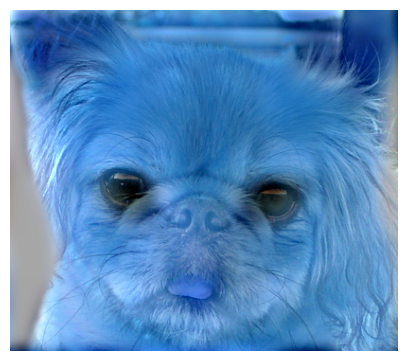

In [99]:
img1= 'C:/Users/ameer/Downloads/hybrid-images/data/cat.bmp'
img2='C:/Users/ameer/Downloads/hybrid-images/data/dog.bmp'
images=[img1 , img2]
final=hybrid_image(images, [7,7], 1)
display(final)

In [93]:
# def output_vis(image):
#     """ Display hybrid image comparison for report. Visualisation shows 5 images
#     reducing in size to simulate viewing the image from a distance.
#     """
#     print("Creating visualisation...")

#     num = 5  # Number of images to display.
#     gap = 2  # Gap between images (px).

#     # Create list of images.
#     image_list = [image]
#     max_height = image.shape[0]
#     max_width = image.shape[1]

#     # Add images to list and increase max width.
#     for i in range(1, num):
#         tmp = cv2.resize(image, (0, 0), fx=0.5 ** i, fy=0.5 ** i)
#         max_width += tmp.shape[1] + gap
#         image_list.append(tmp)

#     # Create space for image stack.
#     stack = np.ones((max_height, max_width, 3)) * 255

#     # Add images to stack.
#     current_x = 0
#     for img in image_list:
#         stack[
#             max_height - img.shape[0] :, current_x : img.shape[1] + current_x, :
#         ] = img
#         current_x += img.shape[1] + gap

#     return stack

In [94]:
# image = [img1,img2]
# output_vis(image)